In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import * 
from tensorflow.keras.models import * 
from tensorflow.keras.optimizers import * 
from tensorflow.keras.metrics import * 


This notebook is inspired by [Temporal Fusion Transformers](https://arxiv.org/pdf/1912.09363) architecture

In [45]:
df    = pd.read_csv('../data/clean.csv', index_col=0)
train = df[df.index < '2015-01-01']
test  = df[df.index >= '2015-01-01']

In [46]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [47]:
def create_sequences(data, t = 30):
    X = []
    y = []
    for i in range(t, len(data) - t):
        X.append(data[i-30:i])
        y.append(data[i:i+30])
    return np.array(X), np.array(y)
X, y = create_sequences(scaled_data)

In [48]:
X.shape, y.shape

((1034, 30, 25), (1034, 30, 25))

In [29]:
def enc_dec(hidden=64):
    i = Input((30, 25))
    x = LSTM(hidden)(i)
    x = RepeatVector(30)(x)
    x = LSTM(hidden, return_sequences=True)(x)
    x = Dropout(0.1)(x)
    x = TimeDistributed(Dense(25))(x)
    return Model(inputs=[i],outputs=[x])

def enc_dec_att(hidden=64, use_multihead = False):
    i = Input((30, 25))
    x = LSTM(hidden)(i)
    x = RepeatVector(30)(x)
    x = LSTM(hidden, return_sequences=True)(x)
    if use_multihead:
        x = MultiHeadAttention(4, 64)(x,x)
    else:
        x = Attention(use_scale=True)([x,x])
    x = Dropout(0.1)(x)
    x = TimeDistributed(Dense(25))(x)
    return Model(inputs=[i],outputs=[x])


def deep_enc_dec(hidden=64):
    i = Input((30, 25))
    x = LSTM(hidden, return_sequences=True)(i)
    x = LSTM(hidden, return_sequences=True)(x)
    x = LSTM(hidden)(x)
    
    x = RepeatVector(30)(x)
    
    x = LSTM(hidden, return_sequences=True)(x)
    x = LSTM(hidden, return_sequences=True)(x)
    x = LSTM(hidden, return_sequences=True)(x)
    x = Dropout(0.1)(x)
    x = TimeDistributed(Dense(25))(x)
    return Model(inputs=[i],outputs=[x])


model = enc_dec_att()

In [30]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 30, 25)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 64)        │     23,040 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 30, 64)    │          0 │ lstm_32[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 30, 64)    │     33,024 │ repeat_vector_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 30, 64)    │          1 │ lstm_33[0][0],    │
│ (Attention)         │                   │            │ lstm_33[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 30, 64)    │          0 │ attention_1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 30, 25)    │      1,625 │ dropout_21[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,690 (225.35 KB)

 Trainable params: 57,690 (225.35 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.1855 - root_mean_squared_error: 1.2309 - val_loss: 0.0784 - val_root_mean_squared_error: 1.2739
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0823 - root_mean_squared_error: 1.2815 - val_loss: 0.0727 - val_root_mean_squared_error: 1.2364
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0774 - root_mean_squared_error: 1.2720 - val_loss: 0.0712 - val_root_mean_squared_error: 1.2268
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0752 - root_mean_squared_error: 1.2620 - val_loss: 0.0703 - val_root_mean_squared_error: 1.2269
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0742 - root_mean_squared_error: 1.2564 - val_loss: 0.0702 - val_root_mean_squared_error: 1.2285
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0733 - root_mean_squared_error: 1.2467 - val_loss: 0.0700 - val_root_mean_squared_error: 1.2192
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0737 - roo

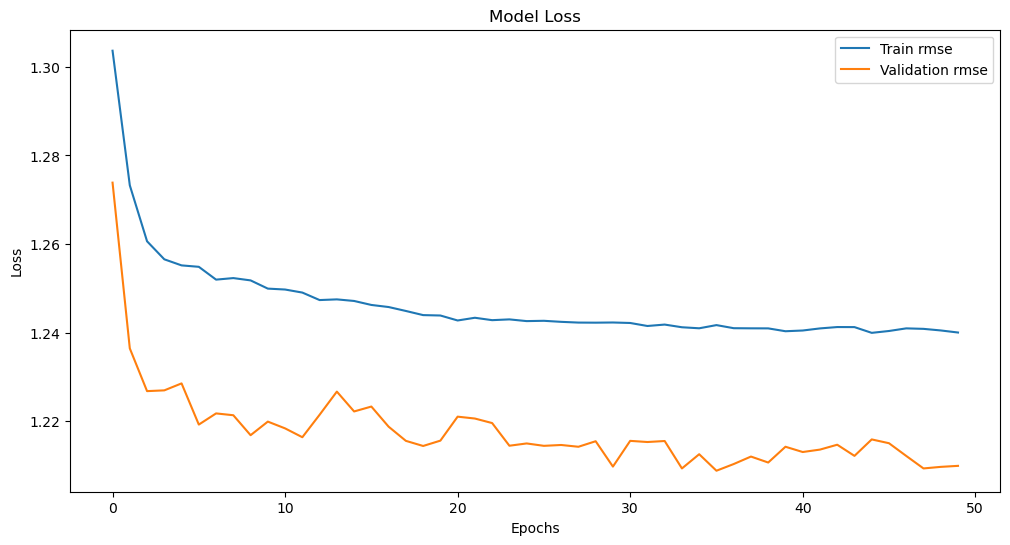

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.3039 - root_mean_squared_error: 1.0708 - val_loss: 0.2772 - val_root_mean_squared_error: 1.0534
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2820 - root_mean_squared_error: 1.0832 - val_loss: 0.2727 - val_root_mean_squared_error: 1.0509
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2788 - root_mean_squared_error: 1.0767 - val_loss: 0.2705 - val_root_mean_squared_error: 1.0550
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2772 - root_mean_squared_error: 1.0762 - val_loss: 0.2688 - val_root_mean_squared_error: 1.0499
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2779 - root_mean_squared_error: 1.0809 - val_loss: 0.2678 - val_root_mean_squared_error: 1.0476
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2740 - root_mean_squared_error: 1.0744 - val_loss: 0.2674 - val_root_mean_squared_error: 1.0471
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2726 - root

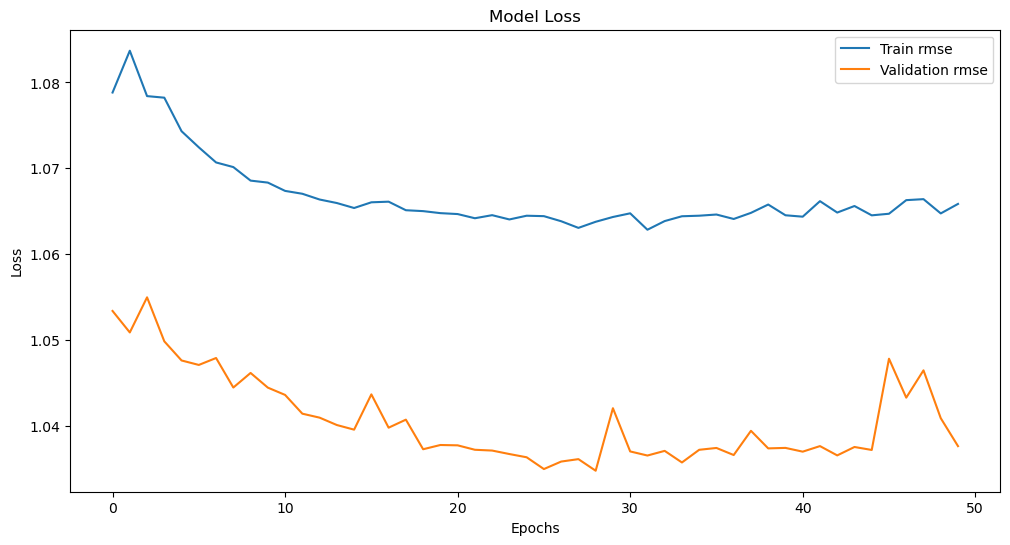

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.2938 - root_mean_squared_error: 1.3176 - val_loss: 0.2260 - val_root_mean_squared_error: 1.4595
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2300 - root_mean_squared_error: 1.5143 - val_loss: 0.2189 - val_root_mean_squared_error: 1.4592
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2218 - root_mean_squared_error: 1.5098 - val_loss: 0.2132 - val_root_mean_squared_error: 1.5087
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2161 - root_mean_squared_error: 1.5450 - val_loss: 0.2087 - val_root_mean_squared_error: 1.4959
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2134 - root_mean_squared_error: 1.5870 - val_loss: 0.2026 - val_root_mean_squared_error: 1.5155
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2061 - root_mean_squared_error: 1.5698 - val_loss: 0.2007 - val_root_mean_squared_error: 1.5401
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2022 - roo

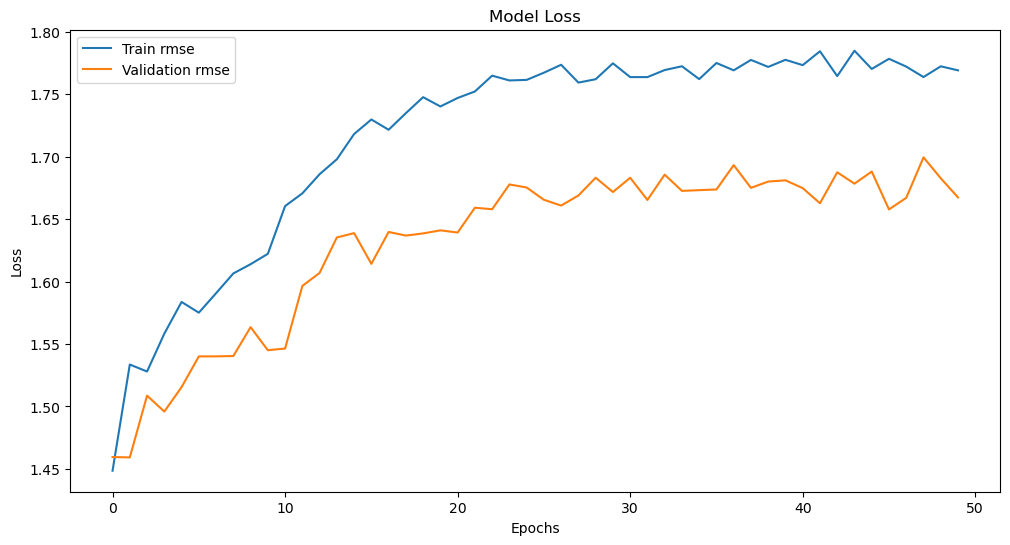

In [32]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

models = {}
for q in [0.1, 0.5, 0.9]:
    model = enc_dec_att()
    opt = Adam(learning_rate=0.01)
    model.compile(loss=lambda y,f: tilted_loss(q, y, f), optimizer=opt, metrics=[RootMeanSquaredError()])
    hist = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[])
    models[q] = model
    plt.figure(figsize=(12, 6))
    plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
    plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [33]:
X, y = create_sequences(scaled_test)

In [34]:
_y = {q : model(X) for q, model in models.items()}

In [35]:
for j in range(y.shape[0]):
    plt.figure(figsize=(100,100))
    for i in range(0, 25):
        plt.subplot(5, 5, i + 1)
        plt.plot(y[j, :, i], label = 'truth')
        for q, p in _y.items():
            plt.plot(p[j,:, i], label=f'perc({q})')
        plt.legend()
    plt.savefig(f'predictions_{j}.png')
    plt.show()
    if j > 5:
        break


KeyboardInterrupt

